# Trade
- Swing trading/long-term trading
    - Exposed to overnight risk (close price previous day might not equal to open 
    price next day if there are major events happening between market closure and
    market open).
- Assume I already have which day to long, which day to short
- Conduct post-trade analysis
- Refine risk management techniques (Comparing starting on 2023-12-22)
    - Boeing: Main character in the events
        - Stock -18.61%

    - Direct competitors
        - Airbus (EPA: AIR): Boeing's primary competitor in commercial aircraft manufacturing
            - Stock +5.93%
        - Lockhead Martin (LMT): More focused on defense but also compete in aerospace
    - Suppliers
        - General Electric (GE): Supplies engines for Boeing aircraft
            - Have presence in aviation, healthcare, power, renewable energy
            - Doesn't seem to be affected
            - Can also supply engines to other aircraft manufacturers (effect on
            stock price is complicated)
    - Customers
        - Alaska Airlines (ALK): Main airline involved
            - Stock -11.73%
        - American Airlines (UAL - NasdaqGS)
            - Stock -4.91%
        - Delta Air Lines (DAL)
            - -11.73%
        - Southwest Airlines
- Trading timing (NYSE) vs news timing
    - The news was updated on January 18, 2024, at 4:36 AM GMT+8, which translates to January 17, 2024, at 3:36 PM Eastern Time (since GMT+8 is 13 hours ahead of Eastern Time). Since the NYSE closes at 4:00 PM ET, this news would have come out just before the market close.
    - Difference stock exchanges might operate at different timings also
- No training and validation - straight go to validation (backtesting)


# Set Up

In [1]:
import os
import ast
import requests
import logging

import yfinance as yf
import pandas as pd
import numpy as np
import finnhub
from dotenv import load_dotenv
from pathlib import Path    
import sys
import time
sys.path.append('../') # Change the python path at runtime

# Self-created modules
from src.utils import path as path_yq
from src.backtesting import Backtest, Strategy


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
load_dotenv()
POLYGON_API_KEY = os.environ.get('POLYGON_API_KEY')

BT_START_DATE = '2023-11-01'
BT_START_STR = '20231101'
BT_END_DATE = '2024-01-31'
BT_END_STR = '20240131'

cur_dir = Path.cwd()
root_dir = path_yq.get_root_dir(cur_dir)

logging.basicConfig(filename=Path.joinpath(root_dir, 'logs', 'trading_system.log'),
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    level=logging.DEBUG)

# Fetch Tick Data

## Polygon

Polygon docs: https://polygon.io/docs/stocks/get_v2_aggs_ticker__stocksticker__range__multiplier___timespan___from___to

- FIXME: The timings include those in pre-market hours
- The timestamp is in ms, not sec

Similar to download data codes
TODO: Assumption: assume other stocks share the same timezone

- The data is incomplete (not every minute)
24265	47739.0	217.6996	217.6800	217.7000	217.7000	217.6800	1705096560000	21	2024-01-12 21:56:00
24266	171.0	217.5423	217.5000	217.5000	217.5000	217.5000	1705096800000	5	2024-01-12 22:00:00

In [7]:
url = f"https://api.polygon.io/v2/aggs/ticker/BA/range/1/minute/{BT_START_DATE}/{BT_END_DATE}?adjusted=true&sort=asc&limit=50000&apiKey={POLYGON_API_KEY}"

# Make the GET request
resp = requests.get(url)

In [23]:
# Check if the request was successful
if resp.status_code == 200:
    # Convert the 'results' list to a DataFrame
    df = pd.DataFrame(resp.json().get('results'))

    # Rename the columns to more descriptive names
    column_mapping = {
        "v": "Volume",
        "vw": "VWAP",
        "o": "Open",
        "c": "Close",
        "h": "High",
        "l": "Low",
        "t": "Timestamp",
        "n": "Transactions"
        # Add more mappings as necessary
    }

    df.rename(columns=column_mapping, inplace=True)

    # Optionally, convert the 'Timestamp' column from Unix milliseconds to a datetime format
    df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='ms')

    # Display the updated DataFrame
    print(df)
else:
    # Handle errors (e.g., logging, raising an exception)
    print(f"Error fetching data: {resp.status_code}, {resp.text}")



       Volume      VWAP      Open   Close      High     Low      Timestamp  \
0       991.0  186.6991  186.6200  186.80  186.8000  186.62  1698829200000   
1       410.0  186.8187  186.8200  186.82  186.8200  186.82  1698829560000   
2      1289.0  187.6589  187.5900  187.70  187.7000  187.59  1698830040000   
3       535.0  188.1637  187.8400  187.96  187.9600  187.84  1698830100000   
4       442.0  188.8297  188.7900  188.79  188.7900  188.79  1698830160000   
...       ...       ...       ...     ...       ...     ...            ...   
32057   340.0  211.3100  211.3100  211.31  211.3100  211.31  1706748780000   
32058   782.0  211.4765  211.3700  211.55  211.5500  211.37  1706748900000   
32059   468.0  211.4948  211.5500  211.55  211.5500  211.55  1706749020000   
32060   540.0  211.4742  211.5499  211.44  211.5499  211.44  1706749080000   
32061   370.0  211.5424  211.5500  211.55  211.5500  211.55  1706749140000   

       Transactions            Datetime  
0                31 2

In [24]:
# Boeing open high low close data
raw_path = Path.joinpath(root_dir, 'data', 'raw', f'BA_OHLC_{BT_START_STR}_{BT_END_STR}.csv')
df.to_csv(raw_path, index=False)

## Yahoo (Outdated)

In [ ]:
# Define the ticker list
ticker_list = ['BA']

# Fetch the data
dl_data = yf.download(ticker_list, start=BT_START_DATE, end=BT_END_DATE) # Auto adjust is false

dl_data = pd.DataFrame(dl_data)
data = dl_data.drop(columns=['Close'], axis=1)
data = data.rename(columns={'Adj Close': 'Close'})
display(data.isna().sum(axis=0)) # Axis=0: along the indices, row-wise opertaion
# Gives the sum for rows in a column
data.index = pd.to_datetime(data.index)
data


In [ ]:
dates = pd.DataFrame(data.index.strftime('%Y-%m-%d'))
# dates.to_csv("trading_dates.csv", index=False)

In [ ]:
# After performing sentiment
stm_path = root_dir.joinpath('data', 'proc', 'boeing_stm_20231101_to_20240131.csv')
news = pd.read_csv(stm_path, index_col=False)
news2 = news[['datetime2', 'news_pol_blob']]
news2

news2.plot()
# # data['Sentiment'] = np.random.random(len(data)) * 2 - 1
# display(len(data))
# sentiment = np.array([0, -1, -0.8, 0, 0, 0]) # Put -1 on 01-05 (Before the whole thing Boeing case appeared after market closed on 01-05 to prepare to trade for 01-08)
# data['Sentiment'] = sentiment
# display(data.tail(20))

In [ ]:
# Ensure datetime2 in news2 is in pandas datetime format
news2['datetime2'] = pd.to_datetime(news2['datetime2'])

# Assuming data.index is already a DatetimeIndex, no need to convert it again
# Just ensure it's sorted
data.sort_index(inplace=True)

# Function to find the closest previous date in data for each date in news2
def find_closest_previous_date(target_date, date_index):
    previous_dates = date_index[date_index <= target_date]
    if not previous_dates.empty:
        return previous_dates.max()
    else:
        return pd.NaT  # Return Not-A-Time (NaT) if no previous date is found

# Apply the function to each date in news2['datetime2']
closest_dates = news2['datetime2'].apply(lambda x: find_closest_previous_date(x, data.index))

# Add this closest date information to news2
news2['closest_date'] = closest_dates
news2

In [ ]:
# TODO: Need to think of how to combine the data (might have many neutral etc.)
# as_index will retain closest_date
news3 = news2.groupby('closest_date', as_index=False)['news_pol_blob'].mean().reset_index(drop=True) 
news3

In [ ]:
merged = pd.merge(data, news3, left_on='Date', right_on='closest_date', how='left')
merged

In [ ]:
# Clean for 2 lines only
merged2 = merged.dropna().reset_index(drop=True)
merged2

# Merge data

In [3]:

def convert_data(row):
    """
    A function from sentiment.ipynb.
    """
    try:
        # First, try to evaluate the row as a list
        evaluated = ast.literal_eval(row)
        # If the result is a list, return it directly
        if isinstance(evaluated, list):
            return evaluated
        # If not, it's already the correct type (int, float, etc.)
        return evaluated
    except ValueError:
        # Handle the case where the row is not a valid Python literal
        # This could be a string that should not be converted
        return row
    except SyntaxError:
        # Handle syntax errors which might occur if ast.literal_eval can't parse the string
        return row
    except Exception as e:
        print(f'Exception: {e}')
        return row

score_path = root_dir.joinpath('data', 'proc', f'BA_score_{BT_START_STR}_{BT_END_STR}.csv') # TODO: Change dates
df9 = pd.read_csv(score_path, index_col=False)

# Apply the conversion function to each specified column
for col in df9.columns:
    df9[col] = df9[col].apply(convert_data)
df9['datetime2'] = pd.to_datetime(df9['datetime2'])

# print(df8.equals(df7))
# print(type(df8['datetime2'][0]))

In [4]:
# Fetch and sort tick data
# Boeing open high low close data
raw_path = Path.joinpath(root_dir, 'data', 'raw', f'BA_OHLC_{BT_START_STR}_{BT_END_STR}.csv')
tick = pd.read_csv(raw_path, index_col=False)
tick['Datetime'] = pd.to_datetime(tick['Datetime'])
tick = tick.sort_values(by='Datetime')

# Make sure the tick data is within backtest date range
tick = tick[(tick['Datetime'] >= BT_START_DATE) & (tick['Datetime'] <= BT_END_DATE)]
tick

,Volume,VWAP,Open,Close,High,Low,Timestamp,Transactions,Datetime
0,991.0,186.6991,186.6200,186.8000,186.8000,186.6200,1698829200000,31,2023-11-01 09:00:00
1,410.0,186.8187,186.8200,186.8200,186.8200,186.8200,1698829560000,5,2023-11-01 09:06:00
2,1289.0,187.6589,187.5900,187.7000,187.7000,187.5900,1698830040000,29,2023-11-01 09:14:00
3,535.0,188.1637,187.8400,187.9600,187.9600,187.8400,1698830100000,34,2023-11-01 09:15:00
4,442.0,188.8297,188.7900,188.7900,188.7900,188.7900,1698830160000,27,2023-11-01 09:16:00
...,...,...,...,...,...,...,...,...,...
31393,1009.0,199.7495,199.7500,199.7500,199.7500,199.7500,1706658600000,7,2024-01-30 23:50:00
31394,250.0,199.6644,199.6500,199.6500,199.6500,199.6500,1706658720000,4,2024-01-30 23:52:00
31395,315.0,199.7283,199.7369,199.7369,199.7369,199.7369,1706658960000,11,2024-01-30 23:56:00
31396,503.0,199.7896,199.7999,199.7999,199.7999,199.7999,1706659080000,6,2024-01-30 23:58:00


In [5]:
tick[tick['Datetime'] >= '2024-01-12 21:47:23'].head()

,Volume,VWAP,Open,Close,High,Low,Timestamp,Transactions,Datetime
24265,47739.0,217.6996,217.6800,217.7000,217.7000,217.6800,1705096560000,21,2024-01-12 21:56:00
24266,171.0,217.5423,217.5000,217.5000,217.5000,217.5000,1705096800000,5,2024-01-12 22:00:00
24267,202.0,217.6949,217.6900,217.6999,217.6999,217.6900,1705096920000,3,2024-01-12 22:02:00
24268,119.0,217.6883,217.6892,217.6892,217.6892,217.6892,1705097280000,5,2024-01-12 22:08:00
24269,100.0,217.6900,217.6900,217.6900,217.6900,217.6900,1705097520000,1,2024-01-12 22:12:00


In [6]:
# Assuming data.index is already a DatetimeIndex, no need to convert it again
df9['datetime2'] = pd.to_datetime(df9['datetime2'])
tick['Datetime'] = pd.to_datetime(tick['Datetime'])

# Make sure to sort first
df9 = df9.sort_values(by='datetime2')
tick = tick.sort_values(by='Datetime')

# Function to find the closest previous date in tick for each date in news2
def find_closest_prev_date(target_date, date_col):
    # The information gotten at this time point can only be used in the next time point
    prev_dates = date_col[date_col <= target_date] 
    if not prev_dates.empty:
        return prev_dates.max()
    else:
        # Can happen when the news is earlier than all the tick data
        print(f"WARNING. Previous date not found for {target_date}")
        print(date_col)
        return pd.NaT  # Return Not-A-Time (NaT) if no previous date is found

# Apply the function to each date in news2['datetime2']
closest_dates = df9['datetime2'].apply(lambda x: find_closest_prev_date(x, tick['Datetime']))

# Add this closest date information to news2
df9['closest_date'] = closest_dates
df9.sort_values(by='datetime2')
df9.reset_index(inplace=True, drop=True)
df9

WARNING. Previous date not found for 2023-11-01 05:39:51
0       2023-11-01 09:00:00
1       2023-11-01 09:06:00
2       2023-11-01 09:14:00
3       2023-11-01 09:15:00
4       2023-11-01 09:16:00
                ...        
31393   2024-01-30 23:50:00
31394   2024-01-30 23:52:00
31395   2024-01-30 23:56:00
31396   2024-01-30 23:58:00
31397   2024-01-31 00:00:00
Name: Datetime, Length: 31398, dtype: datetime64[ns]


,id,datetime2,cln_hdl,cln_smr,cln_news,cln_hdl_lemma,cln_smr_lemma,cln_news_lemma,cln_hdl_pol_blob,cln_smr_pol_blob,...,cln_hdl_lemma_pol_bert_score,cln_smr_lemma_pol_bert_score,cln_news_lemma_pol_bert_score,cln_hdl_pol_finbert_score,cln_smr_pol_finbert_score,cln_news_pol_finbert_score,cln_hdl_lemma_pol_finbert_score,cln_smr_lemma_pol_finbert_score,cln_news_lemma_pol_finbert_score,closest_date
0,123559928,2023-11-01 05:39:51,"[Ford, GM bumped to buy Boeing gets 2 upgrades...",[Goldman Sachs upgraded Simon Property Group (...,[Investing.com — Here is your Pro Recap of the...,"[Ford , GM bumped buy Boeing get 2 upgrade : 4...",[Goldman Sachs upgraded Simon Property Group (...,[Investing.com — Pro Recap biggest analyst pic...,[0.0],[0.0],...,0.727060,-0.689266,-0.340141,0.894530,0.549459,0.360264,0.641842,0.836147,0.400344,NaT
1,123544219,2023-11-01 11:39:06,[UPDATE 2-Spirit Aero cuts 737 fuselage delive...,[Spirit AeroSystems on Wednesday announced $10...,"[(Adjusts shares in paragraph 5, adds Airbus c...",[UPDATE 2-Spirit Aero cut 737 fuselage deliver...,[Spirit AeroSystems Wednesday announced $ 101 ...,"[( Adjusts share paragraph 5 , add Airbus comm...",[0.0],"[0.0, 0.0625, 0.0]",...,0.142053,-0.793133,-0.597804,-0.943793,-0.335737,0.295100,-0.900221,-0.361670,0.448931,2023-11-01 11:39:00
2,123566505,2023-11-01 13:30:29,"[Compared to Estimates, Spirit Aerosystems (SP...",[Although the revenue and EPS for Spirit Aeros...,"[For the quarter ended September 2023, Spirit ...","[Compared Estimates , Spirit Aerosystems ( SPR...",[Although revenue EPS Spirit Aerosystems ( SPR...,"[quarter ended September 2023 , Spirit Aerosys...",[0.0],[0.15],...,0.174489,0.000000,-0.215470,0.000000,0.000000,0.354270,0.000000,0.000000,0.530006,2023-11-01 13:30:00
3,123545059,2023-11-01 14:21:57,[Morning Brew: AMDs Q4 Guidance Weighs on Stoc...,[Advanced Micro Devices (NASDAQ:AMD) stock was...,[Advanced Micro Devices (NASDAQ:AMD) stock was...,[Morning Brew : AMDs Q4 Guidance Weighs Stock ...,[Advanced Micro Devices ( NASDAQ : AMD ) stock...,[Advanced Micro Devices ( NASDAQ : AMD ) stock...,[-0.3],"[0.1527777777777778, 0.22727272727272727, -0.06]",...,-0.744470,-0.263412,-0.343342,-0.958961,-0.322292,-0.101700,-0.852977,-0.267872,0.130774,2023-11-01 14:21:00
4,123567205,2023-11-01 22:24:31,[UPDATE 1-US Air Force blows up Minuteman III ...,[The U.S. Air Force said on Wednesday it had b...,[Nov 1 (Reuters) - The U.S. Air Force said on ...,[UPDATE 1-US Air Force blow Minuteman III test...,[U.S. Air Force said Wednesday blown Minuteman...,[Nov 1 ( Reuters ) - U.S. Air Force said Wedne...,[0.0],"[-0.4, -0.25, 0.0]",...,-0.733265,-0.253360,0.317687,-0.892588,-0.872526,-0.066805,0.000000,0.000000,-0.047870,2023-11-01 22:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,125415682,2024-01-30 21:10:56,[Boeing Seen Narrowing Q4 Loss Amid 737 Max Gr...,[Dow Jones giant Boeing reports Q4 results ear...,[Dow Jones giant Boeing reports Q4 results ear...,[Boeing Seen Narrowing Q4 Loss Amid 737 Max Gr...,[Dow Jones giant Boeing report Q4 result early...,[Dow Jones giant Boeing report Q4 result early...,[0.0],"[0.05, 0.1]",...,-0.737527,-0.239781,-0.239781,-0.965217,-0.952749,-0.952749,-0.965217,-0.944420,-0.944420,2024-01-30 21:09:00
547,125415680,2024-01-30 22:23:48,"[Hawaiian Airlines ekes out Q4 revenue beat, e...",[Hawaiian Holdings (HA) — the parent company o...,[Hawaiian Holdings (HA) — the parent company o...,"[Hawaiian Airlines ekes Q4 revenue beat , earn...",[Hawaiian Holdings ( HA ) — parent company Haw...,[Hawaiian Holdings ( HA ) — parent company Haw...,[0.0],"[-0.06666666666666667, -0.15555555555555559, 0...",...,-0.776986,-0.258785,-0.224460,-0.381478,-0.922368,-0.055458,-0.667220,-0.905073,0.281039,2024-01-30 22:21:00
548,125415679,2024-01-30 22:39:00,"[Boeings Earnings Are Coming., Investors Are W...",[The list of points to watch when the jet make...,[The number of watch items in Boeings fourth-q...,"[Boein

In [7]:
# Drop the NaT in find previous closest dates
def drop_na(df):
    # Drop all the news_content with na
    print(f"Before dropping na: {df.isna().sum().sum()}")
    df1 = df.dropna()
    df1.reset_index(inplace=True, drop=True)
    print(f"After dropping na: {df.isna().sum().sum()}")
    return df1

drop_na(df9).head()

Before dropping na: 1
After dropping na: 1


,id,datetime2,cln_hdl,cln_smr,cln_news,cln_hdl_lemma,cln_smr_lemma,cln_news_lemma,cln_hdl_pol_blob,cln_smr_pol_blob,...,cln_hdl_lemma_pol_bert_score,cln_smr_lemma_pol_bert_score,cln_news_lemma_pol_bert_score,cln_hdl_pol_finbert_score,cln_smr_pol_finbert_score,cln_news_pol_finbert_score,cln_hdl_lemma_pol_finbert_score,cln_smr_lemma_pol_finbert_score,cln_news_lemma_pol_finbert_score,closest_date
0,123544219,2023-11-01 11:39:06,[UPDATE 2-Spirit Aero cuts 737 fuselage delive...,[Spirit AeroSystems on Wednesday announced $10...,"[(Adjusts shares in paragraph 5, adds Airbus c...",[UPDATE 2-Spirit Aero cut 737 fuselage deliver...,[Spirit AeroSystems Wednesday announced $ 101 ...,"[( Adjusts share paragraph 5 , add Airbus comm...",[0.0],"[0.0, 0.0625, 0.0]",...,0.142053,-0.793133,-0.597804,-0.943793,-0.335737,0.295100,-0.900221,-0.361670,0.448931,2023-11-01 11:39:00
1,123566505,2023-11-01 13:30:29,"[Compared to Estimates, Spirit Aerosystems (SP...",[Although the revenue and EPS for Spirit Aeros...,"[For the quarter ended September 2023, Spirit ...","[Compared Estimates , Spirit Aerosystems ( SPR...",[Although revenue EPS Spirit Aerosystems ( SPR...,"[quarter ended September 2023 , Spirit Aerosys...",[0.0],[0.15],...,0.174489,0.000000,-0.215470,0.000000,0.000000,0.354270,0.000000,0.000000,0.530006,2023-11-01 13:30:00
2,123545059,2023-11-01 14:21:57,[Morning Brew: AMDs Q4 Guidance Weighs on Stoc...,[Advanced Micro Devices (NASDAQ:AMD) stock was...,[Advanced Micro Devices (NASDAQ:AMD) stock was...,[Morning Brew : AMDs Q4 Guidance Weighs Stock ...,[Advanced Micro Devices ( NASDAQ : AMD ) stock...,[Advanced Micro Devices ( NASDAQ : AMD ) stock...,[-0.3],"[0.1527777777777778, 0.22727272727272727, -0.06]",...,-0.744470,-0.263412,-0.343342,-0.958961,-0.322292,-0.101700,-0.852977,-0.267872,0.130774,2023-11-01 14:21:00
3,123567205,2023-11-01 22:24:31,[UPDATE 1-US Air Force blows up Minuteman III ...,[The U.S. Air Force said on Wednesday it had b...,[Nov 1 (Reuters) - The U.S. Air Force said on ...,[UPDATE 1-US Air Force blow Minuteman III test...,[U.S. Air Force said Wednesday blown Minuteman...,[Nov 1 ( Reuters ) - U.S. Air Force said Wedne...,[0.0],"[-0.4, -0.25, 0.0]",...,-0.733265,-0.253360,0.317687,-0.892588,-0.872526,-0.066805,0.000000,0.000000,-0.047870,2023-11-01 22:01:00
4,123567203,2023-11-01 22:48:19,[Boeing says cyber incident hit parts business...,"[WASHINGTON (Reuters) -Boeing, one of the worl...","[WASHINGTON (Reuters) -Boeing, one of the worl...",[Boeing say cyber incident hit part business r...,"[WASHINGTON ( Reuters ) -Boeing , one world la...","[WASHINGTON ( Reuters ) -Boeing , one world la...",[0.0],"[0.0, 0.21666666666666667, -0.4]",...,-0.891580,-0.816141,-0.514869,-0.933888,-0.852436,-0.545566,-0.918345,-0.739639,-0.677498,2023-11-01 22:46:00


In [8]:
techs = ['stc', 'blob', 'sid', 'bert', 'finbert']
cols = ['cln_hdl', 'cln_smr', 'cln_news',
        'cln_hdl_lemma', 'cln_smr_lemma', 'cln_news_lemma']

col_list = []
for tech in techs:
    for col in cols:
        col_name = f'{col}_pol_{tech}_score'
        if col_name in df9.columns:
            col_list.append(col_name)
print(col_list)



['cln_hdl_pol_stc_score', 'cln_smr_pol_stc_score', 'cln_hdl_pol_blob_score', 'cln_smr_pol_blob_score', 'cln_news_pol_blob_score', 'cln_hdl_lemma_pol_blob_score', 'cln_smr_lemma_pol_blob_score', 'cln_news_lemma_pol_blob_score', 'cln_hdl_pol_sid_score', 'cln_smr_pol_sid_score', 'cln_news_pol_sid_score', 'cln_hdl_lemma_pol_sid_score', 'cln_smr_lemma_pol_sid_score', 'cln_news_lemma_pol_sid_score', 'cln_hdl_pol_bert_score', 'cln_smr_pol_bert_score', 'cln_news_pol_bert_score', 'cln_hdl_lemma_pol_bert_score', 'cln_smr_lemma_pol_bert_score', 'cln_news_lemma_pol_bert_score', 'cln_hdl_pol_finbert_score', 'cln_smr_pol_finbert_score', 'cln_news_pol_finbert_score', 'cln_hdl_lemma_pol_finbert_score', 'cln_smr_lemma_pol_finbert_score', 'cln_news_lemma_pol_finbert_score']


## Merge Scores between Trading Periods

In [9]:
df_list = []

for col_name in col_list:
    tmp = df9.groupby('closest_date', as_index=False)[col_name].mean().reset_index(drop=True) 
    df_list.append(tmp)
    # display(tmp)
# print(df_list)

# # Assumes df_list has at least two elements
# merged = df_list[0]
# for i in range(1, len(df_list)):
#     merged = pd.merge(left=merged, right=df_list[i], on='closest_date', how='inner')
# merged

from functools import reduce
# A simpler implementation
merged = reduce(lambda left, right: pd.merge(left, right, on='closest_date', how='inner'), df_list)
merged

,closest_date,cln_hdl_pol_stc_score,cln_smr_pol_stc_score,cln_hdl_pol_blob_score,cln_smr_pol_blob_score,cln_news_pol_blob_score,cln_hdl_lemma_pol_blob_score,cln_smr_lemma_pol_blob_score,cln_news_lemma_pol_blob_score,cln_hdl_pol_sid_score,...,cln_news_pol_bert_score,cln_hdl_lemma_pol_bert_score,cln_smr_lemma_pol_bert_score,cln_news_lemma_pol_bert_score,cln_hdl_pol_finbert_score,cln_smr_pol_finbert_score,cln_news_pol_finbert_score,cln_hdl_lemma_pol_finbert_score,cln_smr_lemma_pol_finbert_score,cln_news_lemma_pol_finbert_score
0,2023-11-01 11:39:00,0.830,0.176667,0.0,0.062500,0.114889,0.0,0.062500,0.097016,-0.2960,...,-0.408932,0.142053,-0.793133,-0.597804,-0.943793,-0.335737,0.295100,-0.900221,-0.361670,0.448931
1,2023-11-01 13:30:00,0.430,0.610000,0.0,0.150000,0.006184,0.0,0.150000,-0.005702,0.1779,...,-0.099371,0.174489,0.000000,-0.215470,0.000000,0.000000,0.354270,0.000000,0.000000,0.530006
2,2023-11-01 14:21:00,-0.330,0.653333,-0.3,0.106684,0.110974,-0.3,0.078535,0.121262,-0.5719,...,-0.148375,-0.744470,-0.263412,-0.343342,-0.958961,-0.322292,-0.101700,-0.852977,-0.267872,0.130774
3,2023-11-01 22:01:00,0.600,0.603333,0.0,-0.325000,-0.325000,0.0,0.050000,-0.187500,0.0000,...,0.462276,-0.733265,-0.253360,0.317687,-0.892588,-0.872526,-0.066805,0.000000,0.000000,-0.047870
4,2023-11-01 22:46:00,-0.720,-0.263333,0.0,-0.091667,-0.049907,0.0,-0.091667,-0.065664,-0.5267,...,-0.419641,-0.891580,-0.816141,-0.514869,-0.933888,-0.852436,-0.545566,-0.918345,-0.739639,-0.677498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,2024-01-30 21:09:00,-0.750,0.445000,0.0,0.075000,0.075000,0.0,0.075000,0.075000,-0.3182,...,-0.387261,-0.737527,-0.239781,-0.239781,-0.965217,-0.952749,-0.952749,-0.965217,-0.944420,-0.944420
484,2024-01-30 22:21:00,0.540,0.432500,0.0,0.031684,0.144500,0.0,0.102462,0.206103,-0.4019,...,-0.182459,-0.776986,-0.258785,-0.224460,-0.381478,-0.922368,-0.055458,-0.667220,-0.905073,0.281039
485,2024-01-30 22:38:00,0.525,-0.500000,0.0,0.225000,-0.050000,0.0,0.225000,-0.050000,0.0000,...,0.000000,0.698278,0.720234,0.151111,0.856519,0.000000,0.000000,0.730035,0.000000,0.000000
486,2024-01-30 23:03:00,0.515,-0.192500,0.0,-0.141859,0.066913,0.0,-0.141859,0.009874,0.3416,...,-0.176781,-0.262539,-0.442463,-0.278902,0.000000,-0.928406,-0.508453,0.000000,-0.912366,-0.404513


## Merge Tick Data and Scores

In [10]:
merged2 = pd.merge(left=tick, right=merged, left_on='Datetime', right_on='closest_date', how='left')
merged2.reset_index(inplace=True, drop=True)

In [12]:
merge_path = root_dir.joinpath('data', 'proc', f'BA_merged_{BT_START_STR}_{BT_END_STR}.csv') # TODO: Change dates
merged2.to_csv(merge_path, index=False)

## Simple Post-Trade Analysis

In [ ]:
merged2[merged2.index == 1873]

In [ ]:
# Choose col_name to describe
merged2[col_name].describe()

In [ ]:
# Post-trade analysis
merged2[merged2['Datetime'] >= pd.to_datetime('2024-01-03T14:17:00')]


# Backtesting
- Pros
    - Test single strategy
    - Have optimizer, graphs
- Cons
    - Cannot trade multiple assets FIXME: not applicable to portfolio
    - Does not trade fractional shares
https://kernc.github.io/backtesting.py/#example


- Other backtesting framework: backtrader, zipline - both can do multi-asset trading
- Backtrader works with Pandas DataFrames, CSV, and real-time data feeds from Interactive Brokers, Oanda, and Visual Chart. 
- 2% rule: https://www.investopedia.com/terms/t/two-percent-rule.asp#:~:text=What%20Is%20the%202%25%20Rule,capital%20on%20any%20single%20trade.
- Try to have less than 10% of drawdown: https://www.quora.com/How-do-I-use-the-never-risk-more-than-2-rule-in-Forex-trading


Hypothesis
- Takes in a df from start to end, with all the ticker data (including those NA for sentiment)
- Enters trade at 549 (My information should backfill)
548	308.0	247.7006	247.7000	247.7000	247.7000	247.7000	1704291540000	8	2024-01-03 14:19:00	2024-01-03 14:19:00	0.156808
549	264.0	247.6105	247.6000	247.6000	247.6000	247.6000	1704291780000	9	2024-01-03 14:23:00	NaT	NaN
550	1157.0	247.5724	247.6000	247.5031	247.6001	247.5031	1704291840000	49	2024-01-03 14:24:00	NaT	NaN
- I can compare the results between lemmatization or not, and fix other variables constant
- I can compare the results between different content and fix others constant



In [5]:
class SimpleStmStrat(Strategy):
    """
    Use a proportional amount of cash to trade with the sentiment score indicator.
    """

    def init(self):
        super().init()
        # Initialize additional indicators here if needed
        # self.trade_size = 40 # This times the next open price cannot exceed equity
        self.sl_pct = 0.01
        self.tp_pct = 0.02
        self.risk_per_trade = 0.5 # Maximum of the portfolio on one trade
        # ['cln_hdl_pol_stc_score', 'cln_smr_pol_stc_score', 'cln_hdl_pol_blob_score', 'cln_smr_pol_blob_score', 'cln_news_pol_blob_score', 'cln_hdl_lemma_pol_blob_score', 'cln_smr_lemma_pol_blob_score', 'cln_news_lemma_pol_blob_score', 'cln_hdl_pol_sid_score', 'cln_smr_pol_sid_score', 'cln_news_pol_sid_score', 'cln_hdl_lemma_pol_sid_score', 'cln_smr_lemma_pol_sid_score', 'cln_news_lemma_pol_sid_score', 'cln_hdl_pol_bert_score', 'cln_smr_pol_bert_score', 'cln_news_pol_bert_score', 'cln_hdl_lemma_pol_bert_score', 'cln_smr_lemma_pol_bert_score', 'cln_news_lemma_pol_bert_score', 'cln_hdl_pol_finbert_score', 'cln_smr_pol_finbert_score', 'cln_news_pol_finbert_score', 'cln_hdl_lemma_pol_finbert_score', 'cln_smr_lemma_pol_finbert_score', 'cln_news_lemma_pol_finbert_score']

        self.col = 'cln_news_lemma_pol_sid_score'

        print(self.col)
    def next(self):
        cur_stm = self.data[self.col][-1]
        # print(self.data['closest_date'][-1])
        cur_price = self.data['Close'][-1]

        # print(f"-----{self.data['Datetime'][-1]}-----")
        trade_size = (0.5 * (abs(cur_stm) ** 2) + 0.5) * self.risk_per_trade
        if (cur_stm > 0): # Many losses if I don't take
            self.buy(size=trade_size, sl=(1 - self.sl_pct) * cur_price, tp=(1 + self.tp_pct) * cur_price)
            # If size is a value between 0 and 1, it is interpreted as a fraction of current available liquidity (cash plus Position.pl minus used margin). A value greater than or equal to 1 indicates an absolute number of units.

            # print("Trade here.")
        elif cur_stm < 0:
            self.sell(size=trade_size, sl=(1 + self.sl_pct) * cur_price, tp=(1 - self.tp_pct) * cur_price)
            # print("Trade here.")
        elif (cur_stm == 0):
            pass
            # print("No trade.")
        # print(cur_stm)

merge_path = root_dir.joinpath('data', 'proc', f'BA_merged_{BT_START_STR}_{BT_END_STR}.csv') 
merged2 = pd.read_csv(merge_path, index_col=False)

# Running the backtest
bt = Backtest(data=merged2, 
              strategy=SimpleStmStrat, 
              cash=10000, 
              margin=1,
              commission=.0,
              trade_on_close=False,
              hedging=True
              ) # TODO: Adjust commission
results, pl = bt.run()
# TODO: 
# bt.optimize(maximise='SQN',
#             method='grid',
#             max_tries=None,
#             constraint=None,
#             return_heatmap=True,
#             return_optimization=False # For the method 'skopt
#             ) 
display(results)
print(type(pl))
display(pl)
bt.plot(results=results, plot_return=True) # TODO: Can have filename, plot in html

# These are the main results that we need
print(results.get('Return [%]'), results.get('Max. Drawdown [%]'), results.get('# Trades'), results.get('Win Rate [%]'))


/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_38326/1666116749.py:42: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(data=merged2,


cln_news_lemma_pol_sid_score


Start                                     0.0
End                                   31397.0
Duration                              31397.0
Exposure Time [%]                    86.13606
Equity Final [$]                 10795.809649
Equity Peak [$]                  11556.159405
Return [%]                           7.958096
Buy & Hold Return [%]                6.905782
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -8.162126
Avg. Drawdown [%]                   -0.202014
Max. Drawdown Duration                15198.0
Avg. Drawdown Duration             129.532189
# Trades                                431.0
Win Rate [%]                        39.907193
Best Trade [%]                       6.827858
Worst Trade [%]                     -5.430086
Avg. Trade [%]                    

<class 'pandas.core.series.Series'>


0     -13.0620
1     -18.4124
2     -13.5100
3     -15.2442
4      50.9600
        ...   
426     0.0400
427    -2.2320
428    -3.1200
429    -5.9000
430    17.5500
Name: PnL, Length: 431, dtype: float64

INFO:bokeh.io.state:Session output file 'SimpleStmStrat.html' already exists, will be overwritten.
/Users/tangyiqwan/dev/projects/quant/fyp/notebooks/../src/backtesting/_plotting.py:660: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/tangyiqwan/dev/projects/quant/fyp/notebooks/../src/backtesting/_plotting.py:660: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


7.958096489999898 -8.162125563895417 431.0 39.90719257540603


Normality Test P-Values: Group1=0.0001485383982071653


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


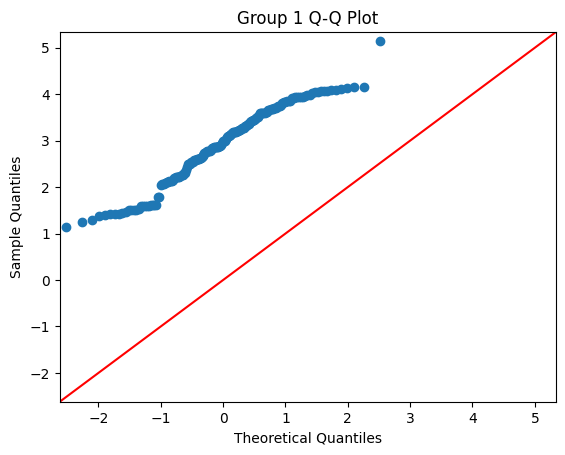

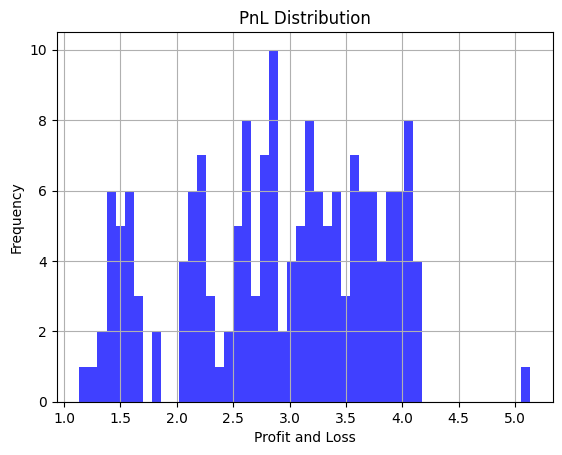

In [14]:
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

pl2 = np.log(pl)
q1 = pl2.quantile(0.25)
q3 = pl2.quantile(0.75)
iqr =q3 - q1

# Define outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

filtered_pl = pl2[(pl2 >= lower_bound) & (pl2 <= upper_bound)]

# Normality Test
_, p_value_normality_group1 = stats.shapiro(filtered_pl)

print(f"Normality Test P-Values: Group1={p_value_normality_group1}")

# Q-Q Plots for Visual Normality Check
sm.qqplot(filtered_pl, line ='45')
plt.title('Group 1 Q-Q Plot')
plt.show()

plt.hist(filtered_pl, bins=50, alpha=0.75, color='blue')
plt.title('PnL Distribution')
plt.xlabel('Profit and Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Archive Strategy

In [38]:
# TODO: Shift the polarity down or the date up (the data with today's date is the data from ytd)
# TODO: How to add the number of positions to put? Or leverage?
# Assume your data includes 'Open', 'Close', and 'Sentiment' columns
# data = pd.read_csv('your_stock_data.csv', parse_dates=True, index_col='Date')

class SentimentStrategy(Strategy):
    """
    
    """
    def init(self):
        super().init()
        # Initialize additional indicators here if needed
        self.long_pos_tsh = 0.4
        self.short_pos_tsh = -0.4
        self.trade_size = 40
        self.sl_pct = 0.005
        self.tp_pct = 0.005
        # self.COL = 'cln_news_pol_sid_score'
        self.COL = 'cln_news_pol_bert_score'
    def next(self):
        
        print(f"-----{self.data['Datetime'][-1]}-----")
        # It doesn't display the first, only start from the next
        # print(self.data)
        curr_stm = self.data[self.COL][-1]
        # print(self.data['closest_date'][-1])

        cur_price = self.data['Close'][-1]
        # TODO: Position represents all trades

        # Strong signals
        if curr_stm > self.long_pos_tsh and self.position.is_short:
            self.position.close()
            self.buy(size=self.trade_size * 2, sl=(1 - self.sl_pct) * cur_price, tp=(1 + self.tp_pct) * cur_price)
            # self.buy(size)
            logging.warning(f"curr_stm > {self.long_pos_tsh} but position is short.")
        elif curr_stm < self.short_pos_tsh and self.position.is_long:
            self.position.close()
            self.sell(size=self.trade_size * 2, sl=(1 + self.sl_pct) * cur_price, tp=(1 - self.tp_pct) * cur_price)
            logging.warning(f"curr_stm < {self.short_pos_tsh} but position is long.")
        else:
            if curr_stm > 0.4:  # Threshold for going long
                self.buy(size=self.trade_size, sl=(1 - self.sl_pct) * cur_price, tp=(1 + self.tp_pct) * cur_price)
            elif curr_stm < -0.4:
                self.sell(size=self.trade_size, sl=(1 + self.sl_pct) * cur_price, tp=(1 - self.tp_pct) * cur_price)
            # for trade in self.trades:
            #     print(f'Trade entry price, time:{trade.entry_price}, {trade.entry_time}')
            #     print(f'Is long, PL: {trade.is_long}, {trade.pl}')

# 1. Slippage: Incorporate slippage into your trades, if your backtesting framework allows.
# 2. Execution Price: Decide whether to execute at the current day's close or the next day's open.
# 3. Risk Management: Implement risk management strategies like stop-loss orders.

# Running the backtest
bt = Backtest(data=merged2, 
              strategy=SentimentStrategy, 
              cash=10000, 
              margin=1,
              commission=.0,
              trade_on_close=False,
              hedging=True
              ) # TODO: Adjust commission
results = bt.run()
# TODO: 
# bt.optimize(maximise='SQN',
#             method='grid',
#             max_tries=None,
#             constraint=None,
#             return_heatmap=True,
#             return_optimization=False # For the method 'skopt
#             ) 
display(results)
bt.plot() # TODO: Can have filename, plot in html

# TODO: Change to use close instead of open, change html location

/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_12957/1080433426.py:55: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(data=merged2,


-----2023-11-01T09:06:00.000000000-----
-----2023-11-01T09:14:00.000000000-----
-----2023-11-01T09:15:00.000000000-----
-----2023-11-01T09:16:00.000000000-----
-----2023-11-01T09:17:00.000000000-----
-----2023-11-01T09:18:00.000000000-----
-----2023-11-01T09:21:00.000000000-----
-----2023-11-01T09:26:00.000000000-----
-----2023-11-01T09:35:00.000000000-----
-----2023-11-01T09:41:00.000000000-----
-----2023-11-01T10:17:00.000000000-----
-----2023-11-01T10:22:00.000000000-----
-----2023-11-01T11:00:00.000000000-----
-----2023-11-01T11:04:00.000000000-----
-----2023-11-01T11:06:00.000000000-----
-----2023-11-01T11:21:00.000000000-----
-----2023-11-01T11:25:00.000000000-----
-----2023-11-01T11:29:00.000000000-----
-----2023-11-01T11:31:00.000000000-----
-----2023-11-01T11:33:00.000000000-----
-----2023-11-01T11:34:00.000000000-----
-----2023-11-01T11:37:00.000000000-----
-----2023-11-01T11:39:00.000000000-----
-----2023-11-01T11:40:00.000000000-----
-----2023-11-01T11:41:00.000000000-----


Start                                     0.0
End                                   31397.0
Duration                              31397.0
Exposure Time [%]                    9.529269
Equity Final [$]                    9765.3465
Equity Peak [$]                       10021.2
Return [%]                          -2.346535
Buy & Hold Return [%]                6.905782
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -6.948564
Avg. Drawdown [%]                   -3.482282
Max. Drawdown Duration                31369.0
Avg. Drawdown Duration                15686.0
# Trades                                 89.0
Win Rate [%]                        43.820225
Best Trade [%]                       0.932668
Worst Trade [%]                     -1.430826
Avg. Trade [%]                    

/Users/tangyiqwan/dev/projects/quant/fyp/notebooks/../src/backtesting/_plotting.py:660: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/tangyiqwan/dev/projects/quant/fyp/notebooks/../src/backtesting/_plotting.py:660: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p2085', ...)

Return in %
- Basic: -4.060443
- Only buy with strong signals: -3.495643
- SID: 11.621226

In [ ]:
results.get('Return [%]')